# 16 - Keras: Clasificación de tendencias politicas en tweets (Perceptrón Multicapa)

* En este notebook vamos a clasificar una serie de tweets etiquetados por un partido político (ciudadanos, podemos, pp, psoe) que corresponden a la tendencia politica de la cuenta que publicó ese tweet,


* El ejercicio que vamos a realizar a continuación es muy similar al realizado en el notebook *13_PoC_Tendencias_Politicas_Twitter_Generacion_Exportacion_Modelos.ipynb* y se pueden comparar los resultados que vamos a obtener con la Red Neuronal respecto a los obtenidos con los modelos generados por los algoritmos de clasificación vistos.


* Los pasos que vamos a dar son los siguientes:

    1. Cargar los datos
    2. Normalizar los tweets (igual que en el notebook *13_PoC_Tendencias_Politicas_Twitter_Generacion_Exportacion_Modelos.ipynb*)
    3. Particionado de datos (Train y Test)
    4. Bolsa de palabras y codificación del target
    5. Definición de la Red Neuronal
    6. Entrenamiento de la Red Neuronal
    7. Evaluación del modelo

<hr>


## Carga de Datos


* El fichero que contiene los tweets lo podemos leer como un '*csv*' con pandas pasandole como separador '***::::***'.


* Este fichero esta estructurado de la siguiente manera
    - **Cuenta**: Cuenta de twitter
    - **Partido**: Partido político al que pertenece (ciudadanos, podemos, pp, psoe)
    - **Timestamp**: Instante en el que se publicó el tweet
    - **Tweet**: Tweet.
    
    
* Leemos los datos y mostramos una muestra:

In [1]:
import pandas as pd

tweets_file = './data/tweets_politica.csv'
df = pd.read_csv(tweets_file, sep='::::', engine='python')
tweets = [tuple(x) for x in df[['tweet', 'partido']].values]
print('Número de Tweets Cargados: {num}'.format(num=len(tweets)))
df.sample(5)

Número de Tweets Cargados: 3843


,cuenta,partido,timestamp,tweet
614,sanchezcastejon,psoe,1555522225,El #28A la frontera entre que España avance o ...
1657,pablocasado_,pp,1557163033,Hoy hace años ETA asesinó al presidente del PP...
589,sanchezcastejon,psoe,1555821160,Mi más enérgica condena a los terribles atenta...
2063,sanchezcastejon,psoe,1558002141,La democracia derrotó a ETA gracias a la unión...
1247,Irene_Montero_,podemos,1556116283,"Nuestro objetivo es gobernar, que haya un gobi..."


<hr>


## Normalización

* Utilizamos ***spaCy*** para la tokenización y normalización.


* Tras realizar un análisis del contenido de los tweets pasamos a realizar las siguientes acciones para ***normalizar*** los tweets:
    1. Pasamos las frases a minúsculas.
    2. Sustituimos los puntos por espacios ya que hay muchas palabras unidas por un punto
    3. Quitamos la almuhadilla de los hashtags para considerarlos como palabras.
    4. Eliminamos los signos de puntuación.
    5. Eliminamos las palabras con menos de 3 caracteres.
    6. Eliminamos las Stop-Words.
    7. Eliminamos los enlaces(http) y las menciones (@)
    8. Pasamos la palabra a su lema


* Todos estos pasos los vamos a realizar en una misma función.


* ***NOTA***: Se pueden realizar más acciones de normalización que las realizadas, como tratamiento de emoticonos, tratamiento especial de referencia a cuentas, hashtags, etc. Al tratarse de un ejemplo didáctica se ha realizado una normalización '*sencilla*'.

In [2]:
import numpy as np
import spacy
nlp = spacy.load('es_core_news_sm')

# Divido los datos en dos listas 
#     X: los tweets
#     y: target (polaridad)

X = [doc[0] for doc in tweets]
y = np.array([doc[1] for doc in tweets])

def normalize(sentenses):
    """normalizamos la lista de frases y devolvemos la misma lista de frases normalizada"""
    for index, sentense in enumerate(sentenses):
        # Tokenizamos el tweets realizando los puntos 1,2 y 3.
        sentense = nlp(sentense.lower().replace('.', ' ').replace('#', ' '))
        # Puntos 4,5,6,7 y 8
        sentenses[index] = ([word.lemma_ for word in sentense if (not word.is_punct)
                             and (len(word.text) > 2) and (not word.is_stop)
                             and (not word.text.startswith('@'))
                             and (not word.text.startswith('http'))
                             and (not ':' in word.text)])
    return sentenses

# Normalizamos las frases
X_norm = normalize(X)

<hr>


## Particionado de Datos (Train y Test)

* Vamos a particionar los datos en conjunto de Train y Test.


* Para este ejemplo nos vamos a quedar con:
    - 80% de datos de entrenamiento
    - 20% de datos de test

In [3]:
from sklearn.model_selection import train_test_split  

X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=0)

print('Número de Tweets para el entrenamiento: {num}'.format(num=len(X_train)))
print('Número de Tweets para el test: {num}'.format(num=len(X_test)))

Número de Tweets para el entrenamiento: 3074
Número de Tweets para el test: 769


<hr>


# Bolsa de palabras y codificación del target


* Al igual que en el notebook *13_PoC_Tendencias_Politicas_Twitter_Generacion_Exportacion_Modelos.ipynb* vamos a trabajar con las 1000 palabras de mayor frecuencia del corpus.

In [4]:
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils


# Bolsa de Palabras
max_words = 1000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_matrix = tokenizer.texts_to_matrix(X_train, mode='count')
X_matrix_test = tokenizer.texts_to_matrix(X_test, mode='count')

# Codificación del Target
encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

Using TensorFlow backend.


<hr>


# Definición de la Red Neuronal



* Para clasificar los tweets en alguna de las 4 tendencias políticas definidas, vamos a crear una red con la siguiente arquitectura:

    - ***Capa 1***: Capa de entrada con 1000 Neuronas (una por palabra del corpus)
    - ***Capa 2***: 20 Neuronas con una función de activación 'relu'
    - ***Capa 3***: 10 Neuronas con una función de activación 'relu'
    - ***Capa 4***: Capa de salida con 4 neurona (una por tendencia política) y una función de activación 'softmax' para que nos "normalice la salida"
    
    
* Para las capas 2 y 3 vamos a poner un dropout del 20% para que nuestra red no se sobreajuste y generalize mejor.
    
    
* Por último utilizaremos:
    - Función de perdida: 'sparse_categorical_crossentropy' (Funciones de Perdida: https://keras.io/losses/)
    - Optimizador: 'adam' (Optimizadores: https://keras.io/optimizers/)
    - Metricas: en cada epoch pediremos que nos muestre el accuracy (Métricas: https://keras.io/metrics/)
    

In [5]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import metrics

np.random.seed(9)
model = Sequential()
model.add(Dense(20, activation='relu', input_dim=max_words))
model.add(Dropout(0.2))
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

* Una vez creada la red mostramos su arquitectura:
    - 1000 Neuronas de entrada
    - Capa 2: 20 Neuronas
    - Conexiones "capa de entrada -> Capa 2" = (1000*20) + 20 = 20020 Conexiones
    - Capa 3: 10 Neuronas
    - Conexiones "Capa 2 -> Capa 3" = (20*10) + 10 = 210 Conexiones
    - Capa de salida: 4 Neuronas
    - Conexiones "Capa 3 -> Capa de salida" = (10*4) + 4 = 44 Conexiones

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                20020     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 44        
Total params: 20,274
Trainable params: 20,274
Non-trainable params: 0
_________________________________________________________________


<hr>


# Entrenamiento de la Red Neuronal


* Como lo que estamos haciendo es un ejemplo didáctico vamos a poner los siguientes valores:
    - *batch_size = 64* : Cada 64 tweets se calculan los nuevos pesos de la red
    - *epochs = 20* : Al ser un dataset relativamente pequeño no es necesario entrenar la red muchas veces, aunque el número de epochs que se debe de poner tienen que depender de como vaya evolucionando (decreciendo) el valor devuelto por la función de perdida.
    - *validation_split = 0.2* 


In [7]:
model.fit(X_matrix, y_train, batch_size=64, epochs=20, verbose=2, validation_split=0.2)

Train on 2459 samples, validate on 615 samples
Epoch 1/20
 - 1s - loss: 1.3759 - acc: 0.2997 - val_loss: 1.3454 - val_acc: 0.4033
Epoch 2/20
 - 0s - loss: 1.3020 - acc: 0.4368 - val_loss: 1.2593 - val_acc: 0.5480
Epoch 3/20
 - 0s - loss: 1.1830 - acc: 0.5401 - val_loss: 1.1073 - val_acc: 0.6715
Epoch 4/20
 - 0s - loss: 1.0138 - acc: 0.6234 - val_loss: 0.9346 - val_acc: 0.7431
Epoch 5/20
 - 0s - loss: 0.8513 - acc: 0.7125 - val_loss: 0.7772 - val_acc: 0.7756
Epoch 6/20
 - 0s - loss: 0.7281 - acc: 0.7527 - val_loss: 0.6708 - val_acc: 0.7951
Epoch 7/20
 - 0s - loss: 0.6249 - acc: 0.7881 - val_loss: 0.5977 - val_acc: 0.8033
Epoch 8/20
 - 0s - loss: 0.5588 - acc: 0.8048 - val_loss: 0.5446 - val_acc: 0.8081
Epoch 9/20
 - 0s - loss: 0.4885 - acc: 0.8312 - val_loss: 0.5154 - val_acc: 0.8130
Epoch 10/20
 - 0s - loss: 0.4469 - acc: 0.8508 - val_loss: 0.4973 - val_acc: 0.8146
Epoch 11/20
 - 0s - loss: 0.3838 - acc: 0.8780 - val_loss: 0.4888 - val_acc: 0.8146
Epoch 12/20
 - 0s - loss: 0.3634 - acc

<hr>


# Evaluamos el modelo

* Pasamos a evaluar el modelo, calculando las siguientes métricas de evaluación:

    1. **Accuracy**
    2. **F1**
    3. **Precision**
    4. **Recall**

In [8]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

y_true = encoder.inverse_transform(y_test.reshape(-1))
y_pred = model.predict_classes(X_matrix_test)
y_pred = encoder.inverse_transform(y_pred.reshape(-1))

print('Accuracy: {acc:0.4f}'.format(acc=accuracy_score(y_true=y_true, y_pred=y_pred)))
print('F1: {f1:0.4f}'.format(f1=f1_score(y_true=y_true, y_pred=y_pred, average='weighted')))
print('Precision: {pre:0.4f}'.format(pre=precision_score(y_true=y_true, y_pred=y_pred, average='weighted')))
print('Recall: {rec:0.4f}'.format(rec=recall_score(y_true=y_true, y_pred=y_pred, average='weighted')))
print(classification_report(y_true=y_true, y_pred=y_pred))
confusion_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=['ciudadanos', 'podemos', 'pp', 'psoe'])

Accuracy: 0.8010
F1: 0.8014
Precision: 0.8043
Recall: 0.8010
              precision    recall  f1-score   support

  ciudadanos       0.78      0.80      0.79       206
     podemos       0.75      0.86      0.80       153
          pp       0.78      0.74      0.76       187
        psoe       0.89      0.82      0.85       223

   micro avg       0.80      0.80      0.80       769
   macro avg       0.80      0.80      0.80       769
weighted avg       0.80      0.80      0.80       769



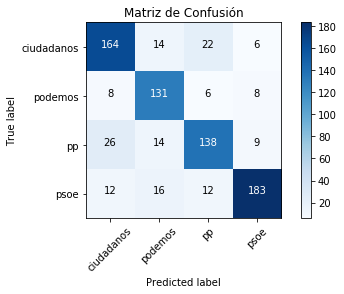

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

def plot_confusion_matrix(cm, classes, title, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure()
plot_confusion_matrix(confusion_matrix, classes=['ciudadanos', 'podemos', 'pp', 'psoe'], 
                      title='Matriz de Confusión')
plt.show()